<h1 align="center">UW CNC Fall Hackathon </h1>  
<h3 align="center"> Dec 4, 2024 </h3>   
<h3 align="center"> mapping mesoscale connectivity between the frontal cortex and thalamus</h3> 
    
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** In this notebook, we will analyze thalamic projections to frontal cortex using a 3D light sheet microscopy dataset from whole mouse brains. While this tutorial focuses on thalamocortical connectivity, the dataset contains connections between the frontal cortex and other brain regions, which have yet to be thoroughly explored. 
    
**Dataset:**  This dataset was collected using the mesoscale anatomy platform established at the Allen Institute for Neural Dynamics. Brain samples are cleared and imaged on a SmartSPIM lightsheet microscope. Images are stitched and fused into a 3D volume and aligned to the Common Coordinate Framework (CCF), which allows for integration between samples. Candidate cell somas are algorithmically detected and then classified as true detections or non-cells using a trained deep neural network. This yields a collection of cells throughout the brain, each of which are localized within CCF space. The datasets in this tutorial have been QC'd to verify accurate cell detection, but this verification has been primarily performed in thalamus. Care should be taken to verify cell counts in other regions before drawing strong conclusions. 
    
**Experiment:** These experiments are focused on the structure of inputs to frontal cortex. Retrograde viruses were injected across the frontal cortex, eliciting expression of nuclear-localized fluorophores in infected cells. These injections label somas at the site of virus delivery, as well as the somas of neurons with axonal projections to that location. The brains in this dataset received 1-3 injections of viruses expressing spectrally distinct fluorophores, and thus each injection is conceptualized as an independent connectivity mapping experiment. While the majority of these viral injections employed AAVrg-XFPs, other reagents were also used to address potential cellular or axonal density based tropism. The location of each injection site was empirically determined.
        
    
**Goal:** This tutorial will show you how to:  
    1. analyze connectivity across brain regions  
    2. work with 3D volumetric microscopy data of whole mouse brains 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: Note for Mathew to remember to include flatmap visualization of injections.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data<br>
    
    

In [2]:
# general imports 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, ListedColormap

import pandas as pd
%matplotlib inline

In [3]:
# specific imports and brain atlas initialization 

from load_data import load_data
import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import BrainGlobeAtlas
atlasapi.config.write_config_value('brainglobe_dir', '/data/.brainglobe') # points to allen mouse atlases pre-loaded in data folder 
atlas = BrainGlobeAtlas('allen_mouse_25um', 
                        check_latest = False) # load CCF mouse brain atlas, 25um resolution 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Break:  
we will start by importing metadata as a df and unpack some of the experimental information

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f69cf7; ">
SdV: It might help to start with picking a brain - what do we know about this brain? Why are we picking it? This might work best starting with metadata, so we can add that shortly, but rather than brain out of a hat, let's motivate why we are looking at this brain.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load data for a single brain 
      
The load_data object class is a wrapper for pulling relevant lightsheet data and data products from the /data folders for a given mouse ID.  

Here, you can see which channels went through each stage of processing.  
(raw image channels > cell detection model applied > transformation to CCF space)
    
(to do - write docstrings for load_data)


In [4]:
mouse_ID = '698035' 
x = load_data(mouse_ID)

Loading data from ../data/SmartSPIM_698035_2023-10-24_18-38-40_stitched_2023-10-28_20-52-51/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: Perhaps it's worth clarifying somewhere that the 639 channel is exclusively used as an autofluorescent channel, whereas all others are signal channels when present. (except in the case of failed injections)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Whole-brain volumes are quite large - each spectral channel is approximately 200 GB in size at full resolution. We can quickly plot compressed versions of the data in different spectral channels using the `plotSlice` function in load_data. 

In [5]:
help(x.plotSlice)

Help on method plotSlice in module load_data:

plotSlice(ch=[], plane='coronal', section=[], extent=[], level=3, ticks=True, printOutput=True) method of load_data.load_data instance
    Plots a single brain slice from the volumetric data in a specified plane.
    
    Parameters
    ----------
    ch : str, optional
        Imaging channel to plot (e.g., "488", "561"). If not specified, defaults to the shortest wavelength available.
        
    plane : str, optional
        Plane in which to view the slice: "coronal", "sagittal", or "transverse". Defaults to "coronal".
        
    section : int or float, optional
        Position along the selected plane, in microns, to slice. If not specified, defaults to the midpoint.
        
    extent : list of float, optional
        4-element list defining the [left, right, bottom, top] extent of the plot in microns.
        If not provided, defaults to the entire image field.
        
    level : int, optional
        Downsampling level for t

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's plot a slice in the coronal plane. If "section" is left blank, it will take us to the middle of the volume. 

Grabbing volumes for level: 3
Plotting coronal axis, section: 5128 (level 3 index: 641)


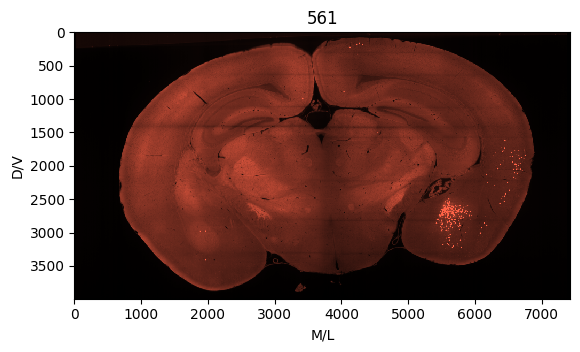

In [8]:
x.plotSlice(ch = "561", plane = "coronal", section = []) 

# note that these slices are not transformed to CCF 
# question about difference between the section and index output here 
# to do - attach units to the function (pixels) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The orientVol function will reshape the data depending on the plane orientation. The shape of the reoriented volume can tell us the total number of sections.

In [9]:
[chVol, _, _, _] = x.orientVol(ch = "561", plane = "coronal", returnLabels = True)
chVol.shape[0]

1282

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: I think the orientation of the data is a bit of a technical detail - I would advise avoiding mention of it unless we think there's an important utility we need to teach them. I've included another method for finding the shape of the volume below, which is just looking at the volume dictionary that load_data constructs at initialization. But this is also fraught - note that the shape will be for the currently held compression level (by default, 3 at initialization). This shape will be larger at different compression hierarchies, illustrated below.

In [10]:
x.vols

{'445': dask.array<getitem, shape=(499, 1282, 929), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>,
 '488': dask.array<getitem, shape=(499, 1282, 929), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>,
 '561': dask.array<getitem, shape=(499, 1282, 929), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>,
 '639': dask.array<getitem, shape=(499, 1282, 929), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>}

In [17]:
x.setLevel(level=0)
x.vols

Grabbing volumes for level: 0


{'445': dask.array<getitem, shape=(3997, 10260, 7439), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>,
 '488': dask.array<getitem, shape=(3997, 10260, 7439), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>,
 '561': dask.array<getitem, shape=(3997, 10260, 7439), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>,
 '639': dask.array<getitem, shape=(3997, 10260, 7439), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: If we want to connect the dimensions of the data to the volumes they'll see in neuroglancer, we'll need to use the 0th level compression (or no compression). Indexing at this level faithfully matches the indices of the raw data, which are the indices that neuroglancer uses. When I wrote the plotSlice function I tried to bridge both of these by designing the function input "section" to be the index of the raw data, which plotSlice converts under the hood to a section index for the compressed data (at the compression level requested). This is why I had the function print both the index of the raw data and the index at that compression level, e.g. "Plotting coronal axis, section 5128 (level 3 index: 641)". My thinking was that this aids transitioning between a quick plotting low resolution version of the data and a much slower plotting of high resolution data for defined windows of the data, specified by the "extent" paramter. But perhaps it's just easier to use neuroglancer for visualization purposes!!

Grabbing volumes for level: 3
Plotting coronal axis, section: 5128 (level 3 index: 641)


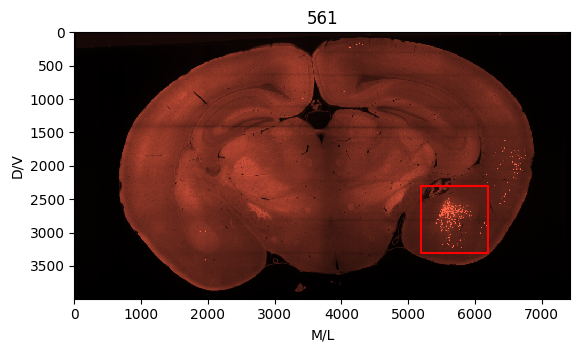

In [33]:
# Get your bearings with a low-resolution version
x.plotSlice(ch = "561", plane = "coronal", section = [])

# Subset to a section of this image for plotting at higher resolution in the next cell
extent = [5200, 6200, 3300, 2300]
square_coord =  ((extent[0], extent[1], extent[1], extent[0], extent[0]),
                 (extent[3], extent[3], extent[2], extent[2],   extent[3]))

plt.plot(*square_coord, c="r")

Grabbing volumes for level: 1
Plotting coronal axis, section: 5130 (level 1 index: 2565)


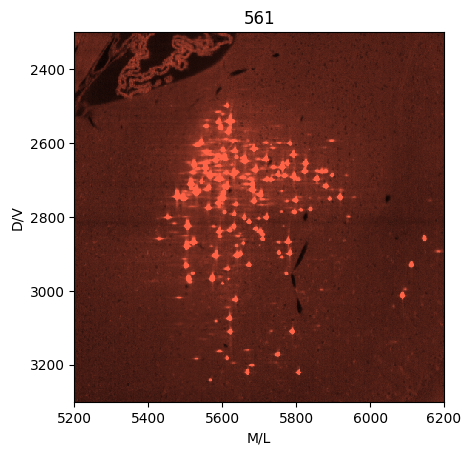

In [35]:
# Here I'm changing the level parameter to load a higher resolution version of the data, but only for a small chunk of the data specified by the extent parameter.
# Otherwise the data will take ages to plot, if the kernel doesn't crash first!
x.plotSlice(ch = "561", plane = "coronal", level = 1, section = [], extent = extent) 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 1:** Try plotting a different slice in a different plane (e.g. "sagittal")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Plotting the data slice by slice in this manner can be slow. Alternatively, we can more readily explore the 3D volumetric anatomy dataset on neuroglancer. 

In [ ]:
# point to neuroglancer links in metadata/qc portal 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Automated Cell Detection**  
    
With this dataset, we can map which brain regions provide input to the frontal cortex. To do so, we need to find all of the cells labelled by each viral injection, and the locations of those cells in the brain. Manually annotating these cells is quite laborious, especially at the whole brain scale. To facilitate quantitative insights from these experiments, cells were automatically detected using machine vision models. The rest of this tutorial will show you how to load and analyze the spatial coordinates of these detected cells. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The `getCellsCCFdf` function loads the spatial coordinates of the detected cells in a given channel. Note that these coordinates are transformed into CCF space. 

In [6]:
help(x.getCellsCCFdf)

Help on method getCellsCCFdf in module load_data:

getCellsCCFdf(ch: list) method of load_data.load_data instance
    Retrieves and formats CCF transformed coordinates of segmented cells into a dataframe. 
    
    Parameters
    ----------
    ch : list of str 
        List of imaging channels to retrieve coordinates from (e.g., ["488", "561"]). 
    
    Returns
    -------
    location_df : pd.DataFrame
        Dataframe where each row is a cell and each column is a coordinate: AP (anterior-posterior), DV (dorsal-ventral), or             ML (medial-lateral), with an additional "channel" column indicating the channel of origin.



In [38]:
cellLocs = x.getCellsCCFdf(["445", "488", "561"])
cellLocs

,AP,DV,ML,channel
0,248,17,259,445
1,259,15,196,445
2,252,15,202,445
3,250,18,194,445
4,241,19,202,445
...,...,...,...,...
536458,246,276,338,561
536459,256,282,335,561
536460,252,282,333,561
536461,250,279,339,561


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #DFF0D8; ">

**Task 2:** How many cells were detected in each channel? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's explore where the targeted cells are located in the brain. Since this project is focused on mapping thalamocortical connections, we'll take a slice of the brain centered around the thalamus and look at a histogram of the cells targeted in that region. We'll plot in the coronal plane. Using the atlas.get_structure_mask function, we can also overlay the brain structure boundaries to help us identify where the cell targets are. 
    
You can play around with the `plane` and `window` parameters to adjust the location and thickness of the slice we plot or the roiList to outline different brain regions. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: This will be a useful chunk of code for me, thanks for writing it!

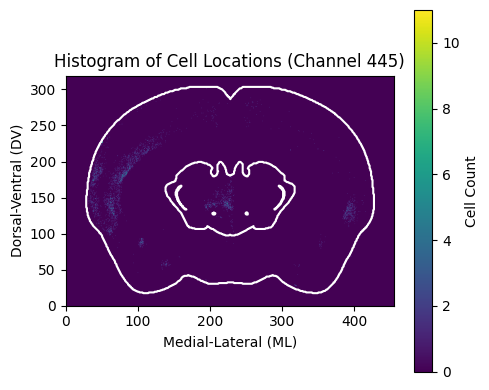

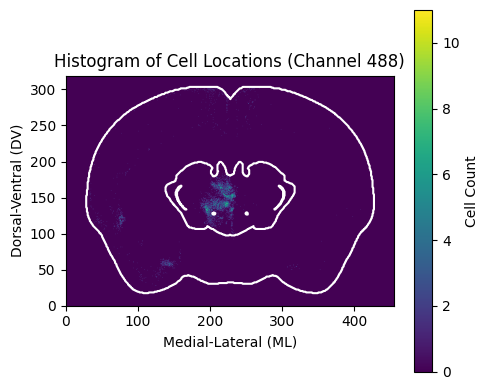

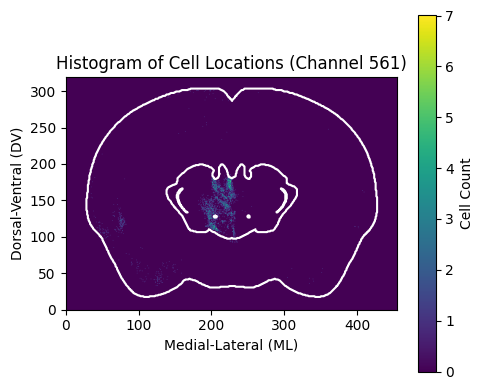

In [39]:
import matplotlib.pyplot as plt
import numpy as np

channel = ["445", "488", "561"]
plane = 250
window = 5
roiList = ["root", "TH"]

# Loop through each channel 
for ch in channel: 
    # Create a figure for each channel
    fig, ax = plt.subplots(figsize=(5, 4))

    # Generate contour outlines for brain structures
    for roi in roiList:
        roi_mask = atlas.get_structure_mask(roi)
        ax.contour(
            roi_mask[plane, :, :],
            levels=[0.5],
            colors="white",
            linewidths=1.5,
            origin="upper"
        )

    # Generate the histogram of cell coordinates
    planeLocs = cellLocs.loc[
        (cellLocs['AP'] >= plane - window) & (cellLocs['AP'] <= plane + window), :
    ]

    xbins = np.arange(0, atlas.get_structure_mask("root").shape[2], 1)
    ybins = np.arange(0, atlas.get_structure_mask("root").shape[1], 1)
    hist, xedges, yedges = np.histogram2d(
        planeLocs[planeLocs['channel'] == ch]["ML"],
        planeLocs[planeLocs['channel'] == ch]["DV"],
        bins=(xbins, ybins),
    )

    # Overlay the heatmap
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap = ax.imshow(
        hist.T,  # Transpose because imshow expects (rows, cols)
        extent=extent,
        origin="upper",
        cmap="viridis",
        alpha=1,
    )

    # Add colorbar and labels
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label("Cell Count")
    ax.set_title(f"Histogram of Cell Locations (Channel {ch})")
    ax.set_xlabel("Medial-Lateral (ML)")
    ax.set_ylabel("Dorsal-Ventral (DV)")

    plt.tight_layout()
    plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: These outputs appear to be flipped. Labelling should be on the right side of the brain, rather than the left. This might be an issue with Nick's updating of the datasets - I'll follow up.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
Focusing on the thalamus, it looks like different injection sites within frontal cortex label different subregions of the thalamus.  

We can pass the coordinates through the `atlas.structure_from_coords` function to identify the brain region each cell is in to quantify differences in brain region targeting across different experimental parameters, such as injection site.     

In [9]:
help(atlas.structure_from_coords)

Help on method structure_from_coords in module brainglobe_atlasapi.core:

structure_from_coords(coords, microns=False, as_acronym=False, hierarchy_lev=None, key_error_string='Outside atlas') method of brainglobe_atlasapi.bg_atlas.BrainGlobeAtlas instance
    Get the structure from a coordinate triplet.
    
    Parameters
    ----------
    coords : tuple or list or numpy array
        Triplet of coordinates.
    microns : bool
        If true, coordinates are interpreted in microns.
    as_acronym : bool
        If true, the region acronym is returned.
        If outside atlas (structure gives key error),
        return "Outside atlas"
    hierarchy_lev : int or None
        If specified, return parent node at thi hierarchy level.
    
    Returns
    -------
    int or string
        Structure containing the coordinates.



In [45]:
brain_region = [] 

# iterate through each coordinate in the df, ignoring the index 
for _, cell in cellLocs.iterrows(): 
    # match the brain structure 
    brain_region.append(atlas.structure_from_coords([ cell['AP'], cell['DV'], cell['ML'] ], as_acronym = True)) 
    
cellLocs['brain_region'] = brain_region
cellLocs

,AP,DV,ML,channel,brain_region
0,248,17,259,445,RSPagl1
1,259,15,196,445,RSPagl1
2,252,15,202,445,Outside atlas
3,250,18,194,445,RSPagl1
4,241,19,202,445,MOs1
...,...,...,...,...,...
536458,246,276,338,561,OLF
536459,256,282,335,561,COAa
536460,252,282,333,561,COAa
536461,250,279,339,561,COAa


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: This function takes a bit of time to run - especially if we want to run it for 80+ injections. A potential alternative to querying the CCF structure at each coordinate and summing across structures is to load the "cell_count_by_region.csv" in the image_cell_quantification directories. The load_data "quantPaths" attribute points to these files.

In [48]:
x.quantPaths

{'445': PosixPath('../data/SmartSPIM_698035_2023-10-24_18-38-40_stitched_2023-10-28_20-52-51/image_cell_quantification/Ex_445_Em_469/cell_count_by_region.csv'),
 '488': PosixPath('../data/SmartSPIM_698035_2023-10-24_18-38-40_stitched_2023-10-28_20-52-51/image_cell_quantification/Ex_488_Em_525/cell_count_by_region.csv'),
 '561': PosixPath('../data/SmartSPIM_698035_2023-10-24_18-38-40_stitched_2023-10-28_20-52-51/image_cell_quantification/Ex_561_Em_593/cell_count_by_region.csv')}

In [58]:
cell_counts = pd.read_csv(x.quantPaths["561"])

# There's other information here as well, but these counts are in the "Left", "Right" and "Total" column.

cell_counts[cell_counts["Acronym"].isin(["TH", "MD", "PVT", "CTXpl"])] # This dataframe contains a row for each structure in the CCF ontology, 
                                                                       # I'm filtering to just a few structures here

,Unnamed: 0,ID,Acronym,Name,Parent Region,Layer,Ancestors,Graph Order,Id,Struct_Info,Struct_area_um3,Left,Right,Total,Left_Density,Right_Density,Total_Density
4,4,695,CTXpl,Cortical plate,Cerebral cortex,NaN,"['root', 'Basic cell groups and regions', 'Cer...",4,695,hemi,1.093212e+11,40720,9602,50322,3.724804e-07,8.783293e-08,2.301567e-07
410,410,549,TH,Thalamus,Interbrain,NaN,"['root', 'Basic cell groups and regions', 'Bra...",641,549,mid,2.123735e+10,7405,584,7989,6.973563e-07,5.499744e-08,3.761769e-07
453,453,362,MD,Mediodorsal nucleus of thalamus,Interbrain,NaN,"['root', 'Basic cell groups and regions', 'Bra...",685,362,hemi,7.372682e+08,1028,9,1037,1.394336e-06,1.220723e-08,7.032719e-07
457,457,149,PVT,Paraventricular nucleus of the thalamus,Interbrain,NaN,"['root', 'Basic cell groups and regions', 'Bra...",692,149,mid,5.127462e+08,1820,302,2122,7.099028e-06,1.177971e-06,4.138500e-06


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To help us assess the connectivity across brain regions, we can use this cellLocs dataframe to construct a connectivity matrix. First, let's filter our dataframe to cells within thalamic subregions. Then, we will use pivot_table to create a connectivity matrix where each row is a channel/injection site, each column is a brain region, and the values are cell counts. 

In [59]:
# thalamic subregions of interest 
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# filter the df for cells within the roiList 
filtered_cellLocs = cellLocs[cellLocs["brain_region"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cellLocs.pivot_table(index = "channel", 
                                      columns = "brain_region", 
                                      aggfunc = "size", 
                                      fill_value = 0)
conn_mat

brain_region,CL,CM,IAD,IMD,MD,PCN,PT,PVT
channel,,,,,,,,
445,57,1364,34,153,997,754,2,156
488,28,751,225,615,1526,11,259,1046
561,69,178,430,113,914,0,486,1891


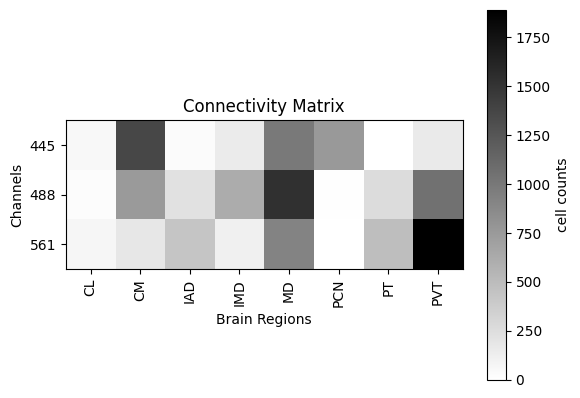

In [34]:
# plot the connectivity matrix as a heatmap 

plt.imshow(conn_mat, cmap="gray_r")
plt.colorbar(label="cell counts")
plt.xticks(ticks=range(len(conn_mat.columns)), labels=conn_mat.columns, rotation=90)
plt.yticks(ticks=range(len(conn_mat.index)), labels=conn_mat.index)
plt.title("Connectivity Matrix")
plt.xlabel("Brain Regions")
plt.ylabel("Channels")
plt.show()

In [ ]:
# to do - add follow up questions here 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: This is another crack at a cartoon representation of counts in each structure. However the dynamic range gets swamped by the labelling at the injection site. Also there's an inherent bias in these types of plots for larger structures (which can have both more cells, and more false positives)

In [110]:
# taking an arbitrary slice of the annotation volume here
chosen_slice = 240
structs_in_slice = np.unique(atlas.annotation[chosen_slice,:,:])

# get the acronym for every ID in that slice
# idk brainglobes well enough to know if there is a more efficient way to do this
roiList = [atlas.structures[struct]["acronym"] for struct in structs_in_slice if struct != 0]

# filter the df for cells within the roiList 
filtered_cellLocs = cellLocs[cellLocs["brain_region"].isin(roiList)] 

# generate connectivity matrix: 
# rows = channels 
# columns = thalamus brain regions 
# values = cell counts 

conn_mat = filtered_cellLocs.pivot_table(index = "channel", 
                                      columns = "brain_region", 
                                      aggfunc = "size", 
                                      fill_value = 0)

# Pad with structs for in roiList for which there are no detected cells
for struct in set(roiList) - set(conn_mat.columns):
    conn_mat[struct] = 0
    
conn_mat

brain_region,AAA,ACAd1,ACAd2/3,ACAd5,ACAd6a,ACAd6b,ACAv1,ACAv2/3,ACAv5,ACAv6a,...,st,vhc,SFO,df,PVa,SCH,RCH,SEZ,SBPV,AHN
channel,,,,,,,,,,,,,,,,,,,,,
445,1,35,736,2427,1947,4,0,2,13,29,...,0,0,0,0,0,0,0,0,0,0
488,2,633,4461,3519,544,9,92,1404,2658,337,...,0,0,0,0,0,0,0,0,0,0
561,5,169,772,516,118,1,66,610,1454,295,...,6,0,0,0,0,0,0,0,0,0


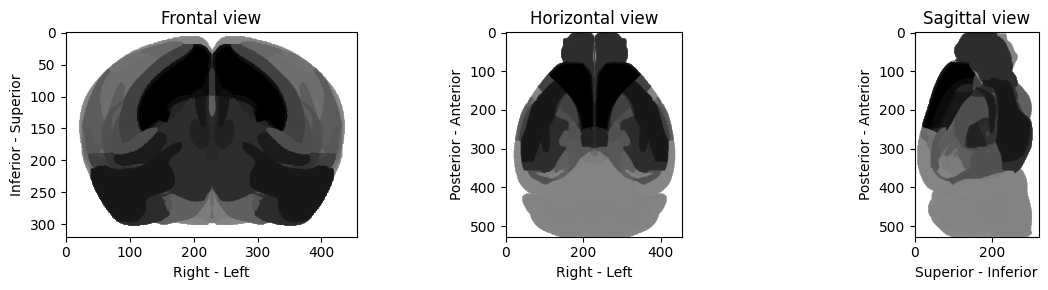

In [112]:
from matplotlib.colors import Normalize

# Generate and combine the masks
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with base value (1)
channel = "488"

for i, roi in enumerate(roiList, start=2):
    roi_mask = atlas.get_structure_mask(roi)
    intensity = conn_mat.loc[channel, roi]
    roi_mask[roi_mask > 0] = intensity
    mask_combined += roi_mask

# Plot the results with LogNorm
space = atlas.space
f, axs = plt.subplots(1, 3, figsize=(12, 3))

for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(
        mask_combined.max(i), 
        cmap="gray_r", 
        norm=Normalize(vmin=0.1, vmax=mask_combined.max())  # Adjust vmin and vmax
    )
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])

plt.tight_layout()
plt.show()

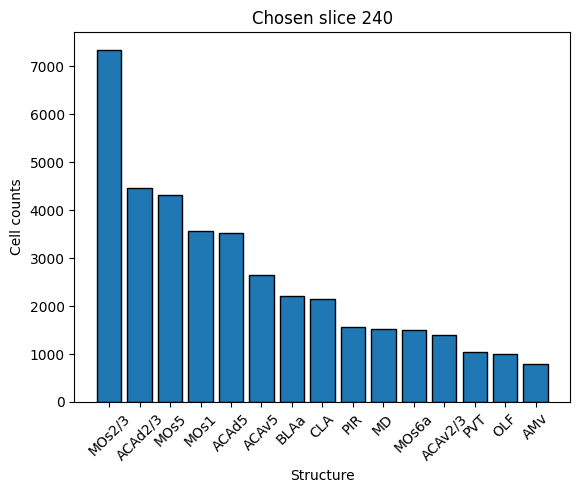

In [170]:

top_n_to_plot = 15
top_structs = conn_mat.T["488"].sort_values(ascending=False).head(top_n_to_plot)
plt.bar(top_structs.index, top_structs, edgecolor = 'k', linewidth = 1)
plt.xticks(rotation=45)
plt.xlabel("Structure")
plt.ylabel("Cell counts")
plt.title("Chosen slice " + str(chosen_slice)); # I added the title to remind myself that this was only looking at 
                                                # the structures within a certain slice, which is a bad way to do it.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #1fa970; ">
MTS: There's probably a way to filter out cortical structures, or filter in only thalamic structures, etc.

In [32]:
# might remove following stuff below this cell

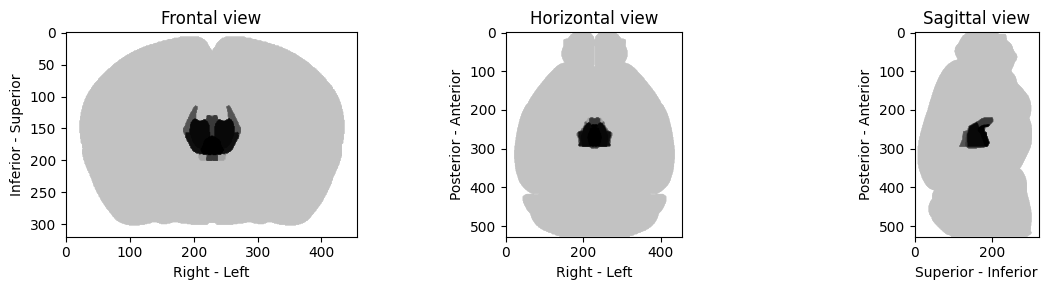

In [19]:
#maybe we don't need this 

from matplotlib.colors import LogNorm

# Generate and combine the masks
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with base value (1)
channel = "445"

for i, roi in enumerate(roiList, start=2):
    roi_mask = atlas.get_structure_mask(roi)
    intensity = conn_mat.loc[channel, roi]
    roi_mask[roi_mask > 0] = intensity
    mask_combined += roi_mask

# Plot the results with LogNorm
space = atlas.space
f, axs = plt.subplots(1, 3, figsize=(12, 3))

for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(
        mask_combined.max(i), 
        cmap="gray_r", 
        norm=LogNorm(vmin=0.1, vmax=mask_combined.max())  # Adjust vmin and vmax
    )
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])

plt.tight_layout()
plt.show()

In [17]:
roiList = ["MD", "PT", "IAD", "PVT", "IMD", "CM", "PCN", "CL"]

# Define the base mask as the root structure
mask_combined = atlas.get_structure_mask("root")
mask_combined[mask_combined > 0] = 1  # Initialize root mask with a base value (1)

# Assign unique values to each ROI and add them to the combined mask
for i, roi in enumerate(roiList, start = 2):  # Start at 2 to avoid overwriting the root
    roi_mask = atlas.get_structure_mask(roi)
    roi_mask[roi_mask > 0] = i  # Assign a unique value based on index
    mask_combined += roi_mask  # Combine the masks


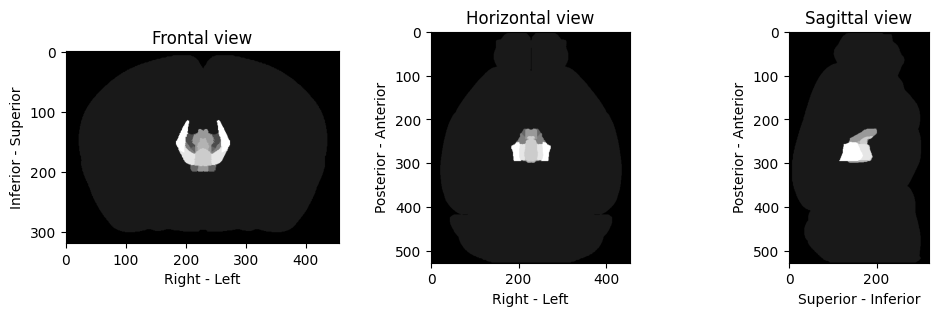

In [18]:
space = atlas.space
f, axs = plt.subplots(1,3, figsize=(12, 3))
for i, (plane, labels) in enumerate(zip(space.sections, space.axis_labels)):
    axs[i].imshow(mask_combined.max(i), cmap="gray")
    axs[i].set_title(f"{plane.capitalize()} view")
    axs[i].set_ylabel(labels[0])
    axs[i].set_xlabel(labels[1])


In [ ]:
# ccfCoordDict = {685903: {'445': [171, 66, 284], '488': [162, 61, 248], '561': [157, 80, 267]},
#                 698035: {'445': [115, 120, 287], '488': [100, 127, 236], '561': [133, 133, 232]},
#                 689238: {'445': [126, 92, 259], '488': [127, 84, 271], '561': [122, 138, 237]},
#                 691387: {'445': [94, 117, 279], '488': [103, 124, 295], '561': [103, 131, 314]},
#                 691388: {'445': [107, 126, 259], '488': [99, 130, 274], '561': [102, 112, 238]},
#                 694512: {'445': [142, 101, 237], '488': [154, 75, 254], '561': [157, 89, 238]},
#                 695721: {'445': [107, 98, 255], '488': [144, 85, 258], '561': [129, 89, 254]},
#                 696668: {'561': [161, 82, 241]},
#                 684812: {'445': [166, 65, 197], '488': [166, 70, 265], '561': [167, 85, 240]},
#                 684821: {'488': [119, 100, 266], '561': [121, 98, 298]},
#                 689237: {'445': [139, 96, 244], '561': [140, 86, 295]},
#                 696669: {'445': [141, 87, 289], '561': [105, 113, 287]},
#                 693977: {'488': [154, 93, 268], '561': [93, 139, 240]},
#                 698927: {'488': [104, 128, 295], '561': [95, 117, 245]},
#                 698928: {'488': [146, 138, 232], '561': [145, 88, 271]},
#                 693979: {'488': [164, 91, 239], '561': [154, 95, 264]},
#                 693980: {'488': [120, 139, 293], '561': [115, 101, 286]},
#                 692909: {'561': [122, 132, 294]},
#                 692907: {'561': [115, 112, 244]},
#                 692912: {'561': [152, 131, 245]},
#                 692911: {'561': [123, 127, 294]},
#                 701750: {'561': [150, 142, 243]},
#                 701751: {'561': [105, 126, 284]},
#                 701754: {'561': [146, 80, 255]},
#                 721832: {'488': [120, 145, 306]}} #manually annotated, estimate injection site later

# virusDict = {685903:'AAVrg-XFP',
#              # 698034:'AAVrg',
#              698035:'AAVrg-XFP',
#              689238:'AAVrg-XFP',
#              691387:'AAVrg-XFP',
#              691388:'AAVrg-XFP',
#              694512:'AAVrg-XFP',
#              695721:'AAVrg-XFP',
#              696668:'AAVrg-XFP',
#              684812:'AAVrg-XFP',
#              684821:'AAVrg-XFP',
#              689237:'AAVrg-XFP',
#              696669:'AAVrg-XFP',
#              693977:"RabV-XFP",
#              698927:"RabV-XFP",
#              698928:"RabV-XFP",
#              693979:"RabV-XFP",
#              693980:"RabV-XFP",
#              692909:"AAVrg-Recombinase",
#              692907:"AAVrg-Recombinase",
#              692912:"AAVrg-Recombinase",
#              692911:"AAVrg-Recombinase",
#              685110:"AAVrg-Recombinase",
#              701750:"RabV-Recombinase",
#              701751:"RabV-Recombinase",
#              701754:"RabV-Recombinase",
#              721832:"AAVrg-XFP"
#             }